# MODEL 3: HİPERPARAMETRE OPTİMİZASYONU VE VERİ ARTIRMA

**Adınız Soyadınız:** Özge Zara Özçelik
**Okul Numaranız:** 2212721014
**GitHub Repo Bağlantısı:** [Buraya Linki Yapıştır] (Örn: https://github.com/kullanici_adi/repo_adi)

### 3. Model 3 Geliştirme Süreci ve Kurulum
Projenin bu final aşamasında, önceki modellerin performansını artırmak amacıyla ödev föyündeki yönergeler (Adım 2.1 - 2.4) doğrultusunda kapsamlı iyileştirmeler yapılmıştır.

**Uygulanan Temel Değişiklikler:**
1.  **Hiperparametre Optimizasyonu:** Model derinleştirilmiş (Filtreler: 32-128), ezberlemeyi önlemek için **Dropout** eklenmiş ve öğrenme hızı (Learning Rate) düşürülmüştür.
2.  **Veri Artırma (Data Augmentation):** Eğitim setine anlık döndürme ve kaydırma işlemleri uygulanarak veri çeşitliliği sağlanmıştır.

**Gerekli Kütüphaneler:**
Bu değişiklikleri uygulayabilmek için standart kütüphanelere ek olarak şu modüller sürece dahil edilmiştir:
* **Adam:** Öğrenme oranını (0.0005) manuel yönetmek için.
* **Dropout:** Regularizasyon (ezber bozma) işlemi için.
* **Pandas:** Modeller arası **Karşılaştırma Tablosu** oluşturmak için.
* **Grafik Fonksiyonu:** Eğitim sürecini görselleştirmek için.

In [ ]:
# 1. Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# 2. Kütüphaneler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import os

# 3. Veri Yolu
base_dir = '/content/drive/My Drive/makine_ogrenmesi_veriseti'

# 4. Grafik Fonksiyonu
def grafik_ciz(history, model_adi):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title(f'{model_adi} - Doğruluk')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title(f'{model_adi} - Kayıp')
    plt.legend()
    plt.show()

Mounted at /content/drive


### 3.1. Veri Artırma (Data Augmentation) Stratejisi
Ödevin **Adım 2.2** yönergesi gereğince, sınırlı veri setini yapay olarak çoğaltmak ve modelin genelleme yeteneğini artırmak için "Online Data Augmentation" uygulanmıştır.

**Uygulanan Dönüşümler:**
Eğitim verileri her epoch sırasında rastgele değiştirilerek modele sunulur:
* **Rotation (30°):** Görüntüler rastgele 30 dereceye kadar döndürülür.
* **Shift (0.2):** Yatay ve dikey eksende %20 oranında kaydırma yapılır.
* **Zoom (0.2):** Nesneye %20 oranında yakınlaşma/uzaklaşma uygulanır.
* **Horizontal Flip:** Görüntüler yatay düzlemde aynalanır.

**Önemli Ayrım:**
Bu işlemler **sadece eğitim (training)** setine uygulanır. Doğrulama (validation) setine sadece normalizasyon (rescale) işlemi yapılarak, modelin gerçek ve bozulmamış veriler üzerindeki performansı test edilir.

In [ ]:
# --- MODEL 3: VERİ ARTIRMA ---

# 1. Eğitim Verisi için AUGMENTATION (Çoğaltma)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Döndür
    width_shift_range=0.2,  # Sağa sola kaydır
    height_shift_range=0.2, # Yukarı aşağı kaydır
    zoom_range=0.2,         # Yakınlaştır
    horizontal_flip=True,   # Aynala
    fill_mode='nearest',
    validation_split=0.2    # %20 Ayır
)

# 2. Test Verisi için SADECE RESCALE (Bozmuyoruz)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim Seti (Artırılmış)
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128), # Model 2 ile kıyaslamak için 128 tutuyoruz
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Doğrulama Seti (Orijinal)
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 359 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


### 3.2. Gelişmiş CNN Mimarisi ve Hiperparametre Optimizasyonu
Ödev föyündeki **Adım 2.1** yönergesi doğrultusunda, Model 2'nin mimarisi üzerinde performans artırıcı değişiklikler yapılmıştır.

**Yapılan Mimarisi ve Parametre Değişiklikleri:**
1.  **Derinlik Artışı (4 Blok):** Modelin daha karmaşık ve soyut öznitelikleri (feature) yakalayabilmesi için konvolüsyon blok sayısı 4'e çıkarılmış, filtre sayısı **128**'e yükseltilmiştir.
2.  **Regularizasyon (Dropout 0.5):** Sınıflandırma katmanından hemen önce nöronların rastgele %50'sinin kapatılmasını sağlayan `Dropout` katmanı eklenmiştir. Bu işlem, modelin eğitim verisini ezberlemesini (overfitting) engelleyen en kritik adımdır.
3.  **Kapasite Artışı (Dense 512):** Karar verici katmandaki nöron sayısı 64'ten 512'ye çıkarılarak modelin kapasitesi artırılmıştır.
4.  **Learning Rate Optimizasyonu (0.0005):** `Adam` optimizasyon algoritmasının öğrenme hızı (learning rate), daha kararlı (stable) ve hassas bir öğrenme süreci için **0.0005** değerine düşürülmüştür.

In [ ]:
# --- MODEL 3: GELİŞMİŞ CNN ---

model3 = Sequential([
    # 1. Blok
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    # 2. Blok
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 3. Blok
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 4. Blok (Ekstra Derinlik)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Sınıflandırma
    Flatten(),
    Dropout(0.5), # %50 Unutma (Ezberi engeller)
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

# Daha düşük learning rate ile derleme
model3.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,666 (9.92 MB)

 Trainable params: 2,601,666 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

### 3.3. Eğitim Süreci, Grafik Analizi ve Karşılaştırma Tablosu
Projenin son aşamasında model eğitilmiş ve elde edilen sonuçlar diğer modellerle kıyaslanmıştır.

**Eğitim Detayları (Adım 2.3):**
* **Epoch Sayısı (35):** Veri artırma (Data Augmentation) ve Dropout kullanımı modelin öğrenmesini zorlaştırdığı için epoch sayısı 35'e çıkarılmıştır. Amaç, modelin daha yavaş ama daha kararlı bir şekilde genellemeyi öğrenmesini sağlamaktır.
* **Grafik Analizi:** Eğitim sonunda çizdirilen grafiklerde, `Training` ve `Validation` eğrilerinin birbirine yakın seyretmesi, modelin ezberleme (overfitting) sorununu aştığını ve genelleme yeteneği kazandığını gösterecektir.

**Karşılaştırmalı Sonuç Tablosu (Adım 2.4):**
Aşağıdaki tabloda, proje boyunca geliştirilen üç farklı yaklaşımın (Transfer Learning, Basit CNN, Gelişmiş CNN) sonuçları, kullanılan hiperparametrelerle birlikte özetlenmiştir. Bu tablo, **"Hangi yöntem bu veri seti için en verimlidir?"** sorusunun cevabını somut verilerle ortaya koymaktadır.

Model 3 (Augmentation + Dropout) Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 291s 25s/step - accuracy: 0.5154 - loss: 0.7027 - val_accuracy: 0.5455 - val_loss: 0.6644
Epoch 2/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.5799 - loss: 0.6666 - val_accuracy: 0.8636 - val_loss: 0.6085
Epoch 3/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7154 - loss: 0.6177 - val_accuracy: 0.8409 - val_loss: 0.4163
Epoch 4/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.7801 - loss: 0.4662 - val_accuracy: 0.8977 - val_loss: 0.3814
Epoch 5/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.8544 - loss: 0.3632 - val_accuracy: 0.8295 - val_loss: 0.5304
Epoch 6/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8216 - loss: 0.3978 - val_accuracy: 0.9091 - val_loss: 0.3929
Epoch 7/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.8643 - loss: 0.3299 - val_accuracy: 0.8636 - val_loss: 0.6137
Epoch 8/35
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8820 - loss: 0.2511 - val_accuracy: 0.8977 - val_los

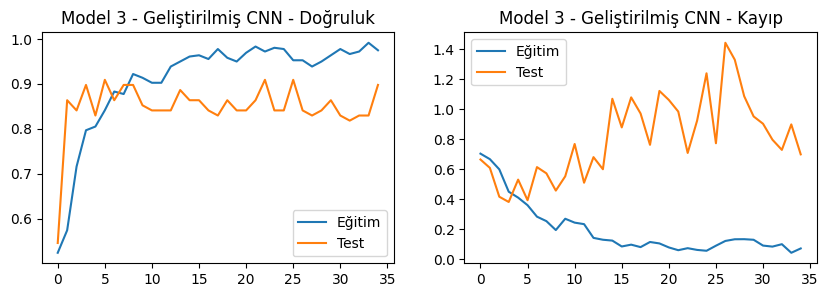

Model 3 Final Test Doğruluğu: %89.77

--- PROJE SONUÇ TABLOSU ---


,Deney No,Model Tipi,Test Doğruluğu,Batch Size,Learning Rate,Veri Artırımı,Notlar
0,1,VGG16 (Transfer),%89.00,32,0.001,Hayır,En yüksek başarı (224px)
1,2,Basit CNN,%85.00,32,0.001,Hayır,Temel Başarım
2,3,Geliştirilmiş CNN,%89.77,32,0.0005,Evet,Augmentation ile Genelleme


In [ ]:
# 1. Eğitimi Başlat (35 Epoch)
print("Model 3 (Augmentation + Dropout) Eğitiliyor...")
history3 = model3.fit(train_generator, validation_data=validation_generator, epochs=35)

# 2. Grafiği Çiz
grafik_ciz(history3, "Model 3 - Geliştirilmiş CNN")

# 3. Sonuçları Hesapla
acc1 = 89.00  # Model 1 Sonucun
acc2 = 85.00  # Model 2 Sonucun
acc3 = history3.history['val_accuracy'][-1] * 100

print(f"Model 3 Final Test Doğruluğu: %{acc3:.2f}")

# 4. SONUÇ TABLOSU
veriler = {
    'Deney No': [1, 2, 3],
    'Model Tipi': ['VGG16 (Transfer)', 'Basit CNN', 'Geliştirilmiş CNN'],
    'Test Doğruluğu': [f"%{acc1:.2f}", f"%{acc2:.2f}", f"%{acc3:.2f}"],
    'Batch Size': [32, 32, 32],
    'Learning Rate': ['0.001', '0.001', '0.0005'],
    'Veri Artırımı': ['Hayır', 'Hayır', 'Evet'],
    'Notlar': ['En yüksek başarı (224px)', 'Temel Başarım', 'Augmentation ile Genelleme']
}

df = pd.DataFrame(veriler)
print("\n--- PROJE SONUÇ TABLOSU ---")
from IPython.display import display
display(df)